# Kaggle Facial Keypoints Detection Baseline

**Tingwen Bao & Sanjay Dorairaj**

**W207-5 - Spring 2017**

## 1. Overview 

This notebook is created to serve as baseline document for 2017 Spring W207-5 Final Project. The Kaggle project selected is the "Facial Keypoints Detection". Link to the project page: (https://www.kaggle.com/c/facial-keypoints-detection)

The baseline was set base on the project tutorial blog post recommened on the project "Deep Learning Tutorial" tab by Daniel Nouri (http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/). Our intent for this baseline is to have the system and GPU successfully set up, understand and be able to successfully run through the method Daniel had used, and come up with ideas of how to improve it moving on.

## 2. System Setup 

It is highly recommended to run below script on GPU. The instance on the project document is no longer available in AWS, so we had figure out our own way of setup. See Facial Key Points Detection Setup & Configuration Document for details to setup, monitor, test, and troubleshooting. 


## 3. Data Preparation 

The training dataset for the Facial Keypoint Detection challenge consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the x and y coordinates) of 15 keypoints, such as left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip, and so on as listed below.


In [1]:
## import libraries
import os
import sys
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import _pickle as pickle
import matplotlib.pyplot as pyplot
import theano

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python3.4/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

# change the directory to where you put the datasets

FTRAIN = '~/Facial_KeyPoints_Detection/training.csv'
FTEST = '~/Facial_KeyPoints_Detection/test.csv'

#FTRAIN = '~/Desktop/W207Final/training.csv'
#FTEST = '~/Desktop/W207Final/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

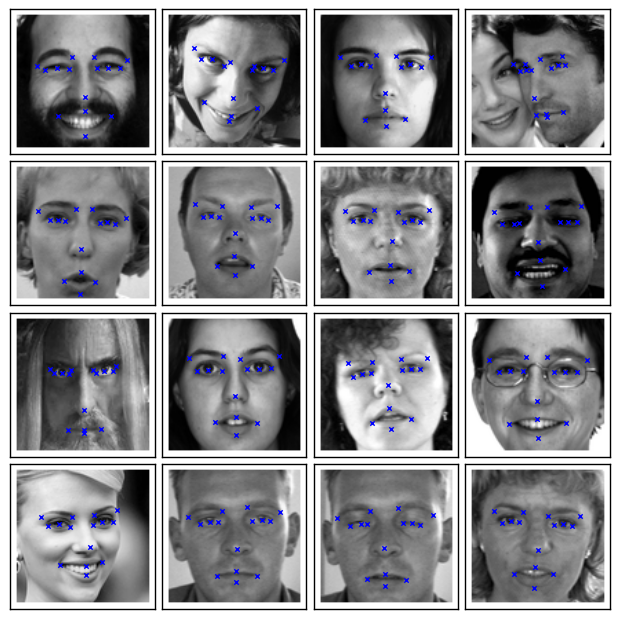

In [10]:
# Plot some training examples to better understand X and y
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y[i], ax)

pyplot.show()

For the keypoints label, more than 1/2 of them only had about 2000+ data available. We currently follow the blog post to exclude them, but it is worth exploring how to use examples with some keypoints missing as training.

Looking at the training examples pictures, we noticed that the dataset pictures is quite diverse: 
* Some examples have more than 1 face in it
* Some examples have their eyes open whereas some have their eyes closed
* Some examples have their mouth open whereas some have their mouth closed
* Face orientation in the example is different. Some face forward whereas some face side ways

## 4. Baseline Models 

### 4.1 Two Layer Simple Neural Net

In [3]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=1000,  # we want to train this many epochs
    verbose=1,  # print out the information during training
    )

X, y = load()
net1.fit(X, y)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fe816e74c50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fe816e74c18>,
     check_input=True, custom_scores=None, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7fe8160a10d0>,
     objective_loss_function=<function squared_error at 0x7fe816eb6d90>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7fe8143746d8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7fe814374710>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     scores_train=[], scores_valid

We are using the "loss" here in above table to evaluate the model. Training and test set loss is calculated with MSE (mean standard error) in the above neural net. 

Nesterov_momentum used here is a gradient descent momentum method. It is basically a jump and adjust method, see details here:
(http://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac)

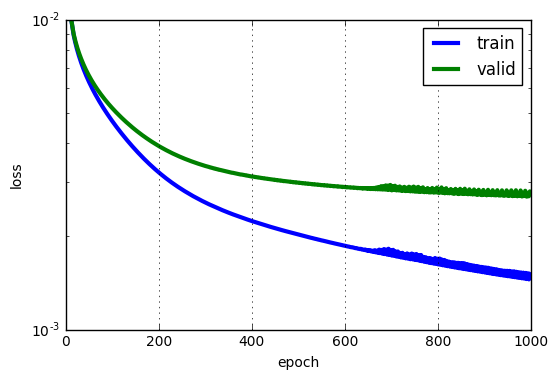

In [4]:
# plot the loss of both training and test dataset
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [5]:
# calculate Kaggle score for this model
np.sqrt(0.00277)*48 # normalize to [-1,1]

2.5262778944526274

ImageId    1783
Image      1783
dtype: int64


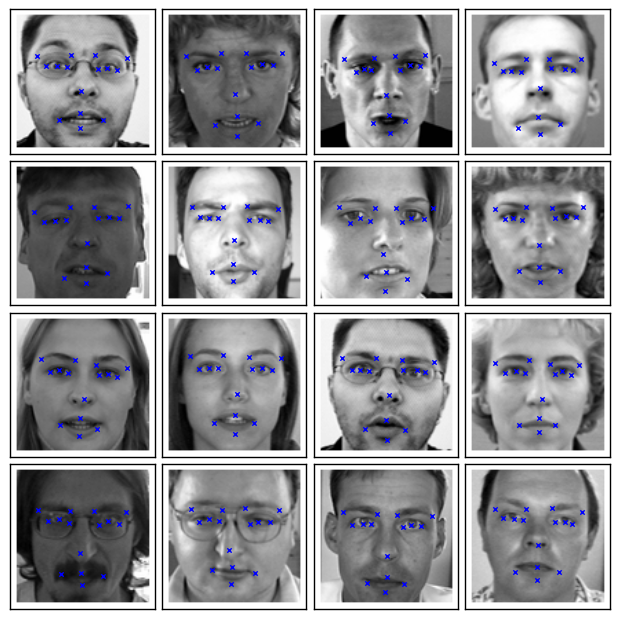

In [6]:
# Plot examples of predictions
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load(test=True)
y_pred = net1.predict(X)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

pyplot.show()

Looking at the prediction examples, most of the prediction keypoints are already pretty accurate. Seems like this algorithm still did not handle glasses well, many of the glass edges are identified as eyebrows. Also, for the only face that is not facing forward, the prediction is pretty off too compare to others. Improvements could be done to help the neural net to understand the face orientations and distinguish between glass and eyebrows.

## 4.2 Convolution Neural Network

Next we are going to try a simple convolution network with 3 convolution and pooling layer and 2 fully connected hidden layer.

In [12]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=1000,
    verbose=1,
    )

X, y = load2d()  # load 2-d data
net2.fit(X, y)


left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f3ff6298be0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f3ff6298ba8>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7f3ff54d5

In [21]:
# Training for 1000 epochs will take a while.  We'll pickle the
# trained model so that we can load it back later:
sys.setrecursionlimit(10000) ## if not reset this, it will get maximum recursion error
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)


In [7]:
# Load from pickle file after first run
net2 = pickle.load(open('net2.pickle','rb'))

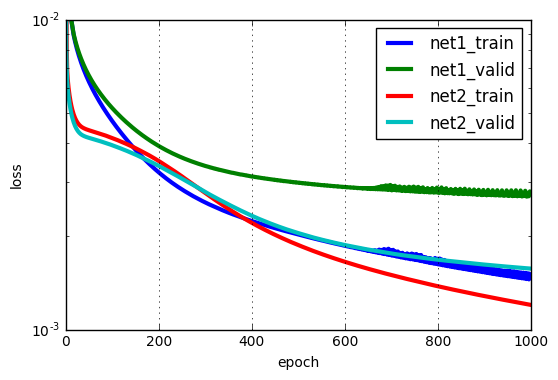

In [8]:
# compare the loss between 2 layer neural net and convolution neural net
net1_train_loss = np.array([i["train_loss"] for i in net1.train_history_])
net1_valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])
pyplot.plot(net1_train_loss, linewidth=3, label="net1_train")
pyplot.plot(net1_valid_loss, linewidth=3, label="net1_valid")
pyplot.plot(net2_train_loss, linewidth=3, label="net2_train")
pyplot.plot(net2_valid_loss, linewidth=3, label="net2_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [15]:
# calculate Kaggle score for this model
np.sqrt(0.00157)*48 # normalize to [-1,1]

1.9019148245912594

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


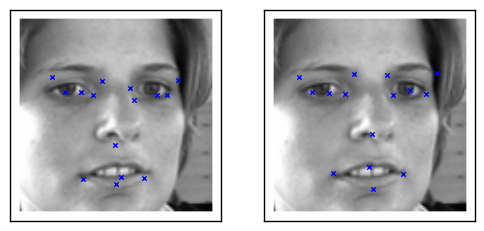

In [22]:
# compare the prediction between 2 layer neural net and convolution neural net
sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred2, ax)
pyplot.show()

## 4.3 CNN with Data Augmentation

Since the the loss curve for CNN also looks overfit at the end, it might be improved by feeding in larger training set. Create a mirror image of the training examples is an artificial way to increase the number of training set and part of the technique of data augmentation. 

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

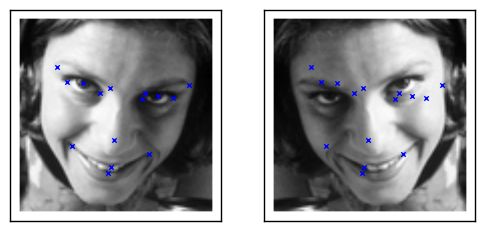

In [24]:
X, y = load2d()
X_flipped = X[:, :, :, ::-1]  # simple slice to flip all images

# plot two images:
fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
pyplot.show()

The image looks right but noticed that the keypoints should be mirrored too

In [25]:
# flip the y labels
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Print out label before and after flip
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

from nolearn.lasagne import BatchIterator

class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [27]:
# CNN with the same structure and parameter as net2 but larger training sample and 3* amount of epoch
net3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    max_epochs=3000,
    verbose=1,
    )


net3.fit(X, y)



# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.09365     0.01720    5.44643  1.88s
      2     0.01359     0.00974    1.39441  1.88s
      3     0.00861     0.00743    1.15783  1.88s
      4     0.00752     0.00699    1.07636  1.88s
      5     0.00711     0.00666    1.06845  1.88s
      6     0.00682     0.00639    1.06699  1.88s
      7     0.00657     0.00618    1.06326  1.88s
      8     0.00637     0.00598    1.06572  1.88s
      9     0.00618     0.00580    1.06505  1.88s
     10     0.00603     0.00564    1.06799  1.88s
     11     0.00588     0.00552    1.06516  1.88s
     12     0.00576     0.00541    1.06464  1.88s
     13     0.00565     0.00529    1.06663  1.88s
     14     0.00554     0.00520    1.06595  1.88s
     15     0.00546     0.00512    1.06574  1.88s
     16     0.00537     0.00503    1.06808  1.88s
     17     0.00530     0.00496    1.06768  1.88s
     18     0.00523     0.00491    1.06497  1.88s
  

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f3ff6298be0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f3fdc3cbef0>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=3000, more_params={},
     objective=<function objective at 0x7f3ff54d5510>,
  

In [28]:
with open('net3.pickle', 'wb') as f:
    pickle.dump(net3, f, -1)

In [11]:
# Load from pickle file after first run
net3 = pickle.load(open('net3.pickle','rb'))

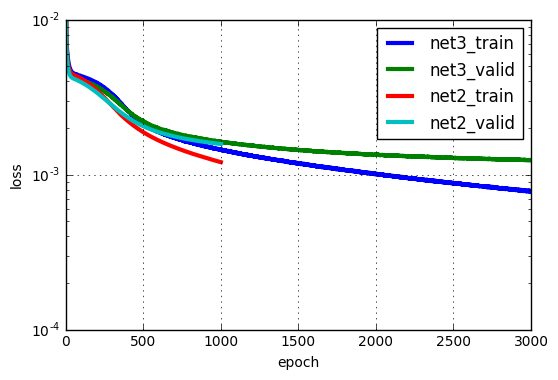

In [12]:
# plot the loss comparison between CNN and CNN with data augmentation
net3_train_loss = np.array([i["train_loss"] for i in net3.train_history_])
net3_valid_loss = np.array([i["valid_loss"] for i in net3.train_history_])
net2_train_loss = np.array([i["train_loss"] for i in net2.train_history_])
net2_valid_loss = np.array([i["valid_loss"] for i in net2.train_history_])
pyplot.plot(net3_train_loss, linewidth=3, label="net3_train")
pyplot.plot(net3_valid_loss, linewidth=3, label="net3_valid")
pyplot.plot(net2_train_loss, linewidth=3, label="net2_train")
pyplot.plot(net2_valid_loss, linewidth=3, label="net2_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [16]:
# calculate Kaggle score for this model
np.sqrt(0.00124)*48 # normalize to [-1,1]

1.690254418719265

The data augmentation does improve the prediction. But still the graph looks overfit and it is something we could further improve.

## 4.4 CNN with Changed Learning Rate and Momentum over time

The net3 in the previous section already takes pretty long to run. We will try here to boosting CNN by adjust its learning rate and momentum. By having learning rate start large and end small, we will help the CNN converge faster.


In [14]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [37]:
net4 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,
    
    # ...
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    # ...
    regression=True,
    # batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000,
    verbose=1,
    )

X, y = load2d()
net4.fit(X, y)



left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f3ff6298be0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f3ff6298ba8>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=3000, more_params={},
     objective=<function objective at 0x7f3ff54d5

In [38]:
with open('net4.pickle', 'wb') as f:
    pickle.dump(net4, f, -1)

In [15]:
# Load from pickle file after first run
net4 = pickle.load(open('net4.pickle','rb'))

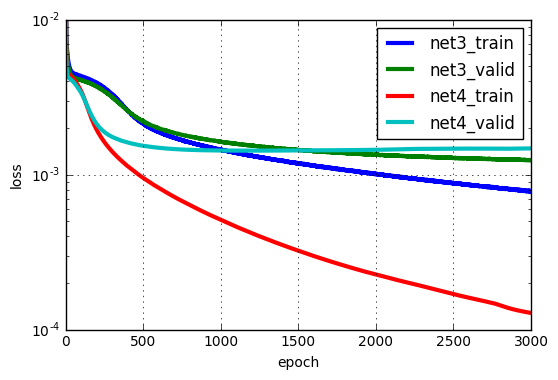

In [16]:
# plot
net3_train_loss = np.array([i["train_loss"] for i in net3.train_history_])
net3_valid_loss = np.array([i["valid_loss"] for i in net3.train_history_])
net4_train_loss = np.array([i["train_loss"] for i in net4.train_history_])
net4_valid_loss = np.array([i["valid_loss"] for i in net4.train_history_])
pyplot.plot(net3_train_loss, linewidth=3, label="net3_train")
pyplot.plot(net3_valid_loss, linewidth=3, label="net3_valid")
pyplot.plot(net4_train_loss, linewidth=3, label="net4_train")
pyplot.plot(net4_valid_loss, linewidth=3, label="net4_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [17]:
# calculate Kaggle score for this model
np.sqrt(0.00147)*48 # normalize to [-1,1]

1.8403477932173582

With only the changing learning rate and momentum, the model is able to converge much faster than net3 but its accuracy is not as good as net3 without face flipping. We then run the net5 below with both data augmentation and boosting.

In [41]:
net5 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,
    # ...
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    # ...
    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000,
    verbose=1,
    )

X, y = load2d()
net5.fit(X, y)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.05135     0.01065    4.82224  1.89s
      2     0.00852     0.00689    1.23754  1.87s
      3     0.00665     0.00590    1.12729  1.87s
      4     0.00595     0.00539    1.10507  1.87s
      5     0.00553     0.00507    1.08978  1.87s
      6     0.00525     0.00484    1.08279  1.87s
      7     0.00505     0.00470    1.07420  1.87s
      8     0.00490     0.00457    1.07367  1.87s
      9     0.00480     0.00448    1.06996  1.87s
     10     0.00472     0.00443    1.06576  1.87s
     11     0.00466     0.00438    1.06498  1.87s
     12     0.00461     0.00436    1.05833  1.87s
     13     0.00459     0.00432    1.06261  1.87s
     14     0.00455     0.00429    1.06113  1.87s
     15     0.00453     0.00429    1.05612  1.87s
     16     0.00452     0.00427    1.05738  1.87s
     17     0.00450     0.00425    1.06089  1.87s
     18     0.00449     0.00425    1.05786  1.87s
  

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f3ff6298be0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f3fe5f07828>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=3000, more_params={},
     objective=<function objective at 0x7f3ff54d5510>,
  

In [42]:

with open('net5.pickle', 'wb') as f:
    pickle.dump(net5, f, -1)

In [17]:
# Load from pickle file after first run
net5 = pickle.load(open('net5.pickle','rb'))

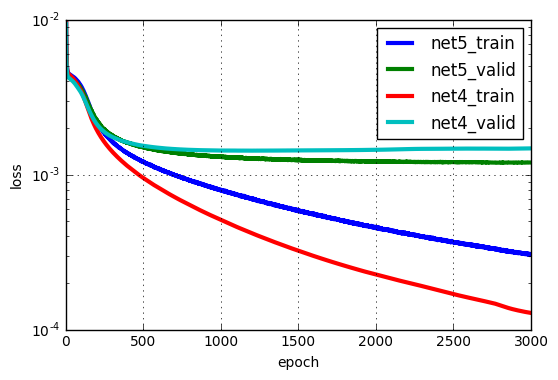

In [18]:
# plot
net5_train_loss = np.array([i["train_loss"] for i in net5.train_history_])
net5_valid_loss = np.array([i["valid_loss"] for i in net5.train_history_])
net4_train_loss = np.array([i["train_loss"] for i in net4.train_history_])
net4_valid_loss = np.array([i["valid_loss"] for i in net4.train_history_])
pyplot.plot(net5_train_loss, linewidth=3, label="net5_train")
pyplot.plot(net5_valid_loss, linewidth=3, label="net5_valid")
pyplot.plot(net4_train_loss, linewidth=3, label="net4_train")
pyplot.plot(net4_valid_loss, linewidth=3, label="net4_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [18]:
# calculate Kaggle score for this model
np.sqrt(0.00119)*48 # normalize to [-1,1]

1.6558260778233929

## 4.5 CNN with Regularization

In model6, we are adding dropout layers between each convolution and pool on top of everything in net5. 

In [44]:
net6 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=500,
    dropout4_p=0.5,  
    hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000,
    verbose=1,
    )

In [45]:

sys.setrecursionlimit(10000)

X, y = load2d()
net6.fit(X, y)

with open('net6.pickle', 'wb') as f:
    pickle.dump(net6, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.06738     0.04640    1.45211  2.01s
      2     0.01833     0.03005    0.60988  1.98s
      3     0.01178     0.02162    0.54494  1.98s
      4     0.00936     0.01671    0.55989  1.98s
      5     0.00815     0.01440    0.56597  1.98s
      6     0.00766     0.01260    0.60766  1.98s
      7     0.00729     0.01210    0.60242  1.98s
      8     0.00698     0.01137    0.61411  1.98s
      9     0.00674     0.01078    0.62519  1.98s
     10     0.00665     0.01022    0.65010  1.98s
     11     0.00640     0.00953    0.67221  1.98s
     12     0.00638     0.00921    0.69214  1.98s
     13     0.00621     0.00937    0.66257  1.98s
     14     0.00607     0.00873    0.69462  1.98s
     15     0.00591     0.00880    0.67224  1.98s
     16     0.00583     0.00836    0.69670  1.98s
     17     0.00575     0.00801    0.71787  1.97s
     18     0.00578     0.00755    0.76614  1.98s
  

In [19]:
# Load from pickle file after first run
net6 = pickle.load(open('net6.pickle','rb'))

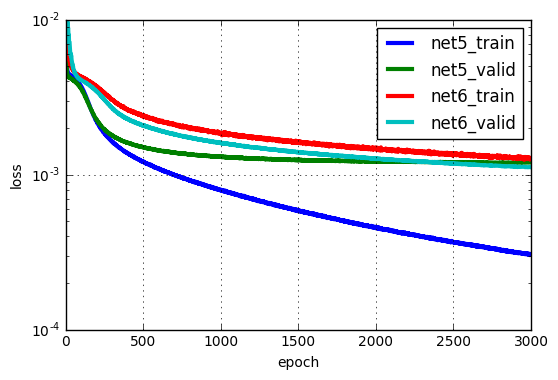

In [20]:
# plot
net5_train_loss = np.array([i["train_loss"] for i in net5.train_history_])
net5_valid_loss = np.array([i["valid_loss"] for i in net5.train_history_])
net6_train_loss = np.array([i["train_loss"] for i in net6.train_history_])
net6_valid_loss = np.array([i["valid_loss"] for i in net6.train_history_])
pyplot.plot(net5_train_loss, linewidth=3, label="net5_train")
pyplot.plot(net5_valid_loss, linewidth=3, label="net5_valid")
pyplot.plot(net6_train_loss, linewidth=3, label="net6_train")
pyplot.plot(net6_valid_loss, linewidth=3, label="net6_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [19]:
# calculate Kaggle score for this model
np.sqrt(0.00111)*48 # normalize to [-1,1]

1.5991997998999374

Net 6 achieves the best result at this point and runs decently fast.

# 5. Summary and Space of Improvement

At this point, we had looked into most of the techniques listed in the tutorial blog post. Both ANN and CNN were tried and had been experimenting with data augmentation, boosting, and regularization a little bit. We will use the Kaggle score of the last model (1.599) to be our baseline for the final project. 

Some of the quick thought about future improvement that we could start from are:
* Adjust the parameter and find the best combination. This include: number of layer, epoch, dropout, learning rate, etc.
* Experiement with different rectifier
* Use the training examples with some missing keypoint value
* Try Tensor Flow on this
* Incorporate the method from below paper: (http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E7403396A760813805F395487239C773?doi=10.1.1.110.4868&rep=rep1&type=pdf) by creating features of picture edges. 

